# Hard spheres model demo on MNIST data

## Imports

In [1]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load data

In [134]:

phis = [0.74] # Add more phis here
path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  400


class          x          y         r
experiment sample                                           
phi-0.74   sample-245     16 -12.952663 -10.228402  1.432632
           sample-245      8   7.611846  -7.796729  1.057895
           sample-245      2 -17.756045  19.323664  0.776842
           sample-245      8  -6.733623  21.188015  1.057895
           sample-245      1  23.330076 -11.149313  0.730000
...                      ...        ...        ...       ...
           sample-201     13   1.560774  -9.533826  1.292105
           sample-201      1   4.417034 -13.831392  0.730000
           sample-201      1   7.749583  17.967815  0.730000
           sample-201      1 -10.482027  -0.638836  0.730000
           sample-201      1  17.057946  -4.977512  0.730000

[800000 rows x 4 columns]

In [213]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

## Build dataset

In [214]:

def get_descriptors(data, experiment, descriptors=["phi"]):
    
    descriptors = []

    phi = float(experiment.split("-")[-1])
    # Assume future data will have more dimensions
    phi = [[phi]] * 3
    descriptors.append(phi)

    # Convert to tensor
    descriptors = torch.tensor(descriptors, dtype=torch.float32)

    # For future compatibility, even if using a single descriptor, 
    # we will keep it as a 2D tensor
    if len(descriptors.shape) == 1:
        descriptors = descriptors.unsqueeze(1)
    
    # In the future descriptors may be tensors instead of scalars, include in design
    if len(descriptors.shape) == 2:
        descriptors = descriptors.unsqueeze(2)

    # descriptors = descriptors.flatten(start_dim=1)

    return descriptors


# Create a dataset
class HSDataset(TensorDataset):
    def __init__(self, dataframe, device="cpu", descriptor_list = ["phi"]):
        print("Creating Dataset")
        print("Descriptor List: ", descriptor_list)
        # Split each experiment and sample into a separate sample

        descriptors = []
        samples = []

        for experiment, sample in dataframe.index.unique(): #TODO: Check if this is the right way to do it
            sample = torch.tensor(dataframe.loc[(experiment, sample),: ].copy().values, dtype=torch.float32, device=device)
            sample_descriptors = get_descriptors(sample, experiment, descriptors=descriptor_list)
            
            samples.append(sample.unsqueeze(0)) # We are creating a 3D tensor of 2D samples
            descriptors.append(sample_descriptors)

        self.x = torch.concat(descriptors) # Descriptors are the input.
        self.y = torch.concat(samples) # Sample point cloud is the target


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        pointcloud = self.x[idx]
        descriptors = self.y[idx]
        return pointcloud, descriptors

dataset = HSDataset(dataframe_scaled, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


/var/folders/q9/ztf8_qts26v_zgn8x6qhqd6h0000gn/T/ipykernel_82899/2827754362.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  sample = torch.tensor(dataframe.loc[(experiment, sample),: ].copy().values, dtype=torch.float32, device=device)


In [215]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([400, 3, 1])
torch.Size([400, 2000, 3])


<Axes: >

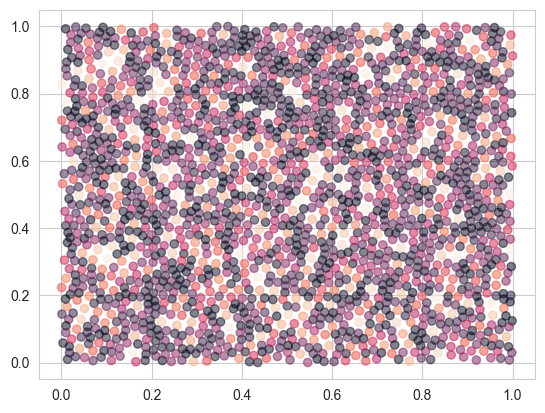

In [216]:
# Create a function that visualizes the point cloud

def plot_pointcloud(pointcloud, ax=None, plot_radius=True):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    xs = pointcloud[:,0]
    ys = pointcloud[:,1]
    rs = pointcloud[:,2]

    if plot_radius:
        ax.scatter(xs, ys, c=rs, s=rs*30, alpha=0.5)
    else:
        ax.scatter(xs, ys, c=rs, alpha=0.5) # TODO: Size of the points is not correct in comparison to the grid size

    return ax

plot_pointcloud(dataset[2][1], plot_radius=False)

## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

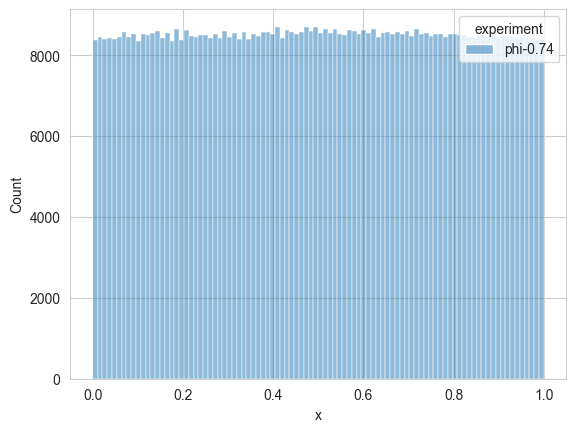

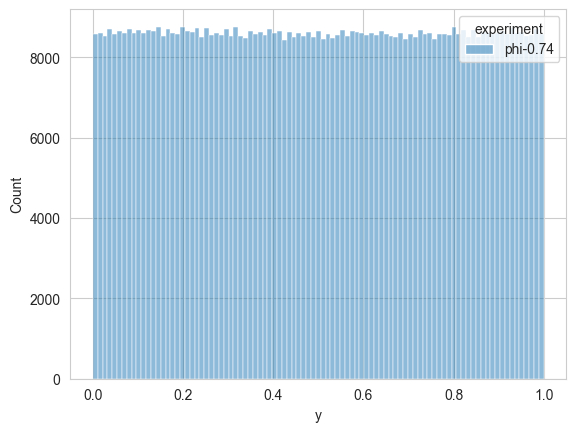

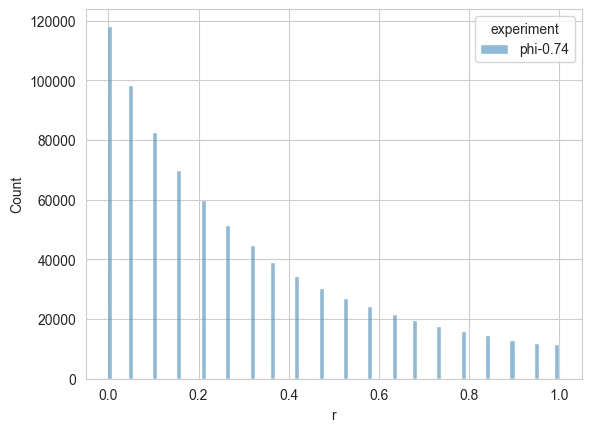

In [221]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{X}$ based on the descriptor(s) $\hat{y}$ and a random noise vector $\hat{r}$.

In [218]:
sample_x = dataset[0:5][0]#.transpose(-1,-2)
sample_y = dataset[0:5][1]

print(sample_x.shape, sample_y.shape)

torch.Size([5, 3, 1]) torch.Size([5, 2000, 3])


## Play around with models

(array([49., 19., 12.,  9.,  6.,  1.,  2.,  0.,  1.,  1.]),
 array([0.00375003, 0.15766613, 0.31158223, 0.46549833, 0.61941443,
        0.77333053, 0.92724663, 1.08116274, 1.23507884, 1.38899494,
        1.54291104]),
 <BarContainer object of 10 artists>)

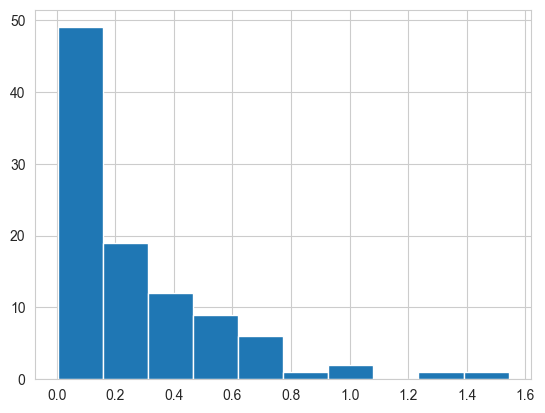

In [219]:
plt.hist(np.random.exponential(0.3, (100,1)))

In [325]:
sample_x_2d = torch.concat([sample_x, sample_x], dim=-1)

sample_x_2d.shape

torch.Size([5, 3, 2])

In [339]:
output_max_samples = 2100
latent_dim = 128
batch_size = sample_x.shape[0]
in_dim = 3 # We have descriptors with three dimensions 
out_dim = 3 # (c), x,y,r


import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(embedding_dim, nhead, num_layers, batch_first=True)
        self.linear = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x, x)
        x = self.linear(x)
        return x

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, output_max_samples, kernel_size=latent_dim, stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
        )

zx = torch.rand(batch_size, output_max_samples, 1) - 0.5 # X is uniform
zy = torch.rand(batch_size, output_max_samples, 1) - 0.5 # Y is uniform
# R is inverse exponential
zr = torch.tensor(np.random.exponential(0.3, (batch_size, output_max_samples, 1)), dtype=torch.float32)
z = torch.cat([zx, zy, zr], dim=-1)

latent2pointcloud = nn.Sequential(
            nn.Conv1d(in_dim, latent_dim, kernel_size=latent_dim, stride=1, padding="same", bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv1d(latent_dim, latent_dim, kernel_size=3, stride=1, padding="same", bias=False),
            nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
        )

print(sample_x_2d.shape)
print(z.shape)

print(desc2latent(sample_x_2d).shape)

print(latent2pointcloud((desc2latent(sample_x_2d))).shape)
print(latent2pointcloud((desc2latent(sample_x_2d).transpose(-1,-2)*z)).shape)

print(summary(latent2pointcloud,depth=1))
print(summary(desc2latent,depth=0))
latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape

torch.Size([5, 3, 2])
torch.Size([5, 2100, 3])


RuntimeError: Given groups=1, weight of size [3, 128, 1], expected input[5, 2100, 129] to have 128 channels, but got 2100 channels instead

In [183]:
dataset[:][1].max()

tensor(2.6378)

In [279]:

class TransformerModel(nn.Module):
    def __init__(self, embedding_dim, output_dim, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(embedding_dim, nhead, num_layers, batch_first=True)
        self.linear = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x, x)
        x = self.linear(x)
        return x

class HSGenerator(nn.Module):
    def __init__(self, output_max_samples, in_dim, latent_dim, out_dim):
        super().__init__()
        # Takes in the input descriptors and returns the output point cloud

        # Maps descriptors to latent space
        self.desc2latent = nn.Sequential(
                    # Input to latent space
                    nn.ConvTranspose1d(in_dim, latent_dim, kernel_size=output_max_samples, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
                )

        self.latent2pointcloud = nn.Sequential(
                    nn.Conv1d(in_dim, latent_dim, kernel_size=latent_dim, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, latent_dim, kernel_size=3, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                )
        

        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.output_max_samples = output_max_samples


    def forward(self, d: torch.tensor):

        # Input d: Batch x Descriptors x 1 # TODO: In the future a single descriptor will be a 1D tensor, changing dimensions to Batch x Descriptors x NFeatures
        # Output: Batch x Samples x 4 (class, x, y, r) 
        batch_size = d.shape[0]
        zx = torch.rand(batch_size, 1, self.output_max_samples) # X is uniform
        zy = torch.rand(batch_size, 1, self.output_max_samples) # Y is uniform
        # R is inverse exponential
        zr = torch.tensor(1/np.random.exponential(0.3, (batch_size, 1, self.output_max_samples)), dtype=torch.float32)
        z = torch.cat([zx, zy, zr], dim=1)#.transpose(-1,-2)
        out = self.desc2latent(d) * z
        out = self.latent2pointcloud(out).transpose(-1,-2)
        # Clip output
        return torch.clip(out, 0, 1)

print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3)(sample_x).shape)

summary(
    HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3), input_data=sample_x
    )


torch.Size([5, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [5, 2000, 3]              --
├─Sequential: 1-1                        [5, 3, 2000]              --
│    └─ConvTranspose1d: 2-1              [5, 64, 2000]             384,000
│    └─LeakyReLU: 2-2                    [5, 64, 2000]             --
│    └─Conv1d: 2-3                       [5, 3, 2000]              192
├─Sequential: 1-2                        [5, 3, 2000]              --
│    └─Conv1d: 2-4                       [5, 64, 2000]             12,288
│    └─LeakyReLU: 2-5                    [5, 64, 2000]             --
│    └─Conv1d: 2-6                       [5, 64, 2000]             12,288
│    └─LeakyReLU: 2-7                    [5, 64, 2000]             --
│    └─Conv1d: 2-8                       [5, 3, 2000]              192
│    └─LeakyReLU: 2-9                    [5, 3, 2000]              --
Total params: 408,960
Trainable params: 408,960
Non-trainable params: 

In [ ]:

class HSGeneratorConv(nn.Module):
    def __init__(self, output_max_samples, in_dim, latent_dim, out_dim):
        super().__init__()
        # Takes in the input descriptors and returns the output point cloud

        # Maps descriptors to latent space
        self.desc2latent = nn.Sequential(
                    # Input to latent space
                    nn.ConvTranspose1d(in_dim, latent_dim, kernel_size=output_max_samples, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
                )

        self.latent2pointcloud = nn.Sequential(
                    nn.Conv1d(in_dim, latent_dim, kernel_size=latent_dim, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, latent_dim, kernel_size=3, stride=1, padding="same", bias=False),
                    nn.LeakyReLU(0.2),
                    nn.Conv1d(latent_dim, out_dim, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.LeakyReLU(0.2),
                )
        

        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.output_max_samples = output_max_samples


    def forward(self, d: torch.tensor):

        # Input d: Batch x Descriptors x 1 # TODO: In the future a single descriptor will be a 1D tensor, changing dimensions to Batch x Descriptors x NFeatures
        # Output: Batch x Samples x 4 (class, x, y, r) 
        batch_size = d.shape[0]
        zx = torch.rand(batch_size, 1, self.output_max_samples) # X is uniform
        zy = torch.rand(batch_size, 1, self.output_max_samples) # Y is uniform
        # R is inverse exponential
        zr = torch.tensor(1/np.random.exponential(0.3, (batch_size, 1, self.output_max_samples)), dtype=torch.float32)
        z = torch.cat([zx, zy, zr], dim=1)#.transpose(-1,-2)
        out = self.desc2latent(d) * z
        out = self.latent2pointcloud(out).transpose(-1,-2)
        # Clip output
        return torch.clip(out, 0, 1)

print(HSGeneratorConv(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3)(sample_x).shape)

summary(
    HSGeneratorConv(output_max_samples=dataset.y.shape[1], latent_dim=64, in_dim=3, out_dim=3), input_data=sample_x
    )


In [280]:
class HSDiscriminator(nn.Module):
    def __init__(self, channels_img=4, features_d=12):
        # Discriminator takes in the point cloud and returns a list of predicted labels (real/fake) 
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=(5,2), stride=(2,1)
            ),  # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d, kernel_size=(5,2), stride=(2,1)),
            self._block(features_d, features_d * 2, kernel_size=(5,2), stride=(2,1)),
            self._block(features_d * 2, features_d, kernel_size=(5,2), stride=(2,1)),
            nn.Conv2d(features_d, 1, kernel_size=(4,2)),  # 1x1
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(40,32),
            nn.LeakyReLU(0.2),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x.unsqueeze(1))

print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1, features_d=4)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=128), input_data=sample_y, depth=2)

torch.Size([5, 3, 1])
torch.Size([5, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [5, 1]                    --
├─Sequential: 1-1                        [5, 1]                    --
│    └─Conv2d: 2-1                       [5, 128, 998, 2]          1,408
│    └─LeakyReLU: 2-2                    [5, 128, 998, 2]          --
│    └─Sequential: 2-3                   [5, 128, 498, 3]          164,096
│    └─Sequential: 2-4                   [5, 256, 248, 4]          328,192
│    └─Sequential: 2-5                   [5, 128, 123, 5]          327,936
│    └─Conv2d: 2-6                       [5, 1, 120, 4]            1,025
│    └─MaxPool2d: 2-7                    [5, 1, 40, 1]             --
│    └─Flatten: 2-8                      [5, 40]                   --
│    └─Linear: 2-9                       [5, 32]                   1,312
│    └─LeakyReLU: 2-10                   [5, 32]                   --
│    └─Linear: 2-11                      [5, 1]              

In [234]:
# if detect_bad_gradients:
#             with autograd.detect_anomaly():
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#                 loss.backward()
#         else:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(
#             model.parameters(), 50
#         )  # Clip gradients

In [310]:
from tqdm import tqdm
from torch import autograd

# Create a GAN class that takes in the generator and discriminator, and the training data
# The GAN class will be responsible for training the generator and discriminator
# The GAN should train the generator to generate images of the digit that is fed as the input

class GAN(nn.Module):
    def __init__(self, generator, discriminator, trainset, testset, device='cpu', batch_size=32, descriptor_loss=False):
        super(GAN, self).__init__()
        self.trainset = trainset
        self.testset = testset
        self.device = device
        self.batch_size = batch_size

        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.criterion = nn.BCELoss()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.002, weight_decay=0.01)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.002, weight_decay=0.01)

        if descriptor_loss:
            self.descriptor_criterion = nn.RMSELoss()
            # TODO: Implement

    def train_n_epochs(self, epochs, batch_size=32):
        print(f'Starting...\nTime: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

        dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)


        for epoch in range(epochs):
            self._train_epoch(epoch, batch_size=batch_size, dataloader=dataloader)
        
    def _physical_loss(self, real_images, fake_images):
        # Loss based on the physical properties of the point cloud
        
        # Loss based on sum of radiuses
        real_radius = real_images[:,2].sum()
        fake_radius = fake_images[:,2].sum()
        radius_loss = torch.abs(real_radius - fake_radius)

        # Loss based on mean and variance of x and y
        real_x_mean = real_images[:,0].mean()
        fake_x_mean = fake_images[:,0].mean()
        x_mean_loss = torch.abs(real_x_mean - fake_x_mean)

        real_x_var = real_images[:,0].var()
        fake_x_var = fake_images[:,0].var()
        x_var_loss = torch.abs(real_x_var - fake_x_var)

        real_y_mean = real_images[:,1].mean()
        fake_y_mean = fake_images[:,1].mean()
        y_mean_loss = torch.abs(real_y_mean - fake_y_mean)

        real_y_var = real_images[:,1].var()
        fake_y_var = fake_images[:,1].var()
        y_var_loss = torch.abs(real_y_var - fake_y_var)

        # TODO Add more physical properties, phi etc.


        loss = radius_loss + x_mean_loss + x_var_loss + y_mean_loss + y_var_loss
        return loss


    def _train_epoch(self, epoch, batch_size=32, dataloader=None):

        if dataloader is None:
            dataloader = DataLoader(self.trainset, batch_size=batch_size, shuffle=True)

        self.generator.train()
        self.discriminator.train()

        mean_loss_d = 0
        mean_loss_g = 0

        d_loss = torch.tensor([0])
        
        for descriptors, real_images in tqdm(dataloader):
            real_images = real_images.to(self.device)
            descriptors = descriptors.to(self.device)

            real_labels = torch.ones(real_images.size(0), 1).to(self.device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(self.device)

            # Train the discriminator       
            self.d_optimizer.zero_grad()

            real_outputs = self.discriminator(real_images)
            d_loss_real = self.criterion(real_outputs, real_labels)
            d_loss_real.backward()

            fake_images = self.generator(descriptors)
            fake_outputs = self.discriminator(fake_images)
            d_loss_fake = self.criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake

            d_grad_norm = torch.nn.utils.clip_grad_norm_(
            self.discriminator.parameters(), 15
            )  # Clip gradients
            self.d_optimizer.step() 
            mean_loss_d += d_loss.item()

            # Train the generator
            self.g_optimizer.zero_grad()

            fake_images = self.generator(descriptors)
            fake_outputs = self.discriminator(fake_images)
            g_loss_gan = self.criterion(fake_outputs, real_labels) # We want the generator to generate images that the discriminator thinks are real
            g_loss_physical = self._physical_loss(real_images, fake_images) 

            g_loss = g_loss_gan + g_loss_physical
            g_loss.backward()

            g_grad_norm = torch.nn.utils.clip_grad_norm_(
            self.generator.parameters(), 15
            )  # Clip gradients
            self.g_optimizer.step()

            mean_loss_g += g_loss.item()


        print(f'Time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")},Epoch {epoch}, D loss: {d_loss.item()}, G_GAN loss: {g_loss.item()}, G_P loss: {g_loss_physical.item()}')

        mean_loss_d /= len(self.trainset)
        mean_loss_g /= len(self.trainset)

        return mean_loss_d, mean_loss_g

    def generate(self, input):
        self.generator.eval()
        return self.generator(input.to(self.device)).detach().cpu()


## Train the model

In [312]:
test_frac = 0.2

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

In [315]:
generator = HSGenerator(output_max_samples=dataset.y.shape[1], in_dim=3, out_dim=3, latent_dim=128)
discriminator = HSDiscriminator(channels_img=1, features_d=64)

print(summary(generator, input_data=sample_x, depth=1))
print(summary(discriminator, input_data=sample_y, depth=1))

gan = GAN(generator, discriminator, trainset, testset, device='cpu')


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [5, 2000, 3]              --
├─Sequential: 1-1                        [5, 3, 2000]              768,384
├─Sequential: 1-2                        [5, 3, 2000]              98,688
Total params: 867,072
Trainable params: 867,072
Non-trainable params: 0
Total mult-adds (G): 8.67
Input size (MB): 0.00
Forward/backward pass size (MB): 31.20
Params size (MB): 3.47
Estimated Total Size (MB): 34.67
Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [5, 1]                    --
├─Sequential: 1-1                        [5, 1]                    207,874
Total params: 207,874
Trainable params: 207,874
Non-trainable params: 0
Total mult-adds (M): 972.46
Input size (MB): 9.60
Forward/backward pass size (MB): 26.09
Params size (MB): 0.83
Estimated Total Size (MB): 36.52


In [316]:
gan.train_n_epochs(200,32)

Starting...
Time: 2024-05-19 13:28:28


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Time: 2024-05-19 13:28:50,Epoch 0, D loss: 0.1859615296125412, G_GAN loss: 12.578214645385742, G_P loss: 9.224944114685059


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:29:12,Epoch 1, D loss: 0.005334666930139065, G_GAN loss: 11.05052375793457, G_P loss: 2.370772361755371


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Time: 2024-05-19 13:29:33,Epoch 2, D loss: 0.00658766645938158, G_GAN loss: 8.28839111328125, G_P loss: 0.5971649885177612


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:29:54,Epoch 3, D loss: 0.0024062178563326597, G_GAN loss: 27.057544708251953, G_P loss: 8.805066108703613


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Time: 2024-05-19 13:30:16,Epoch 4, D loss: 0.043841540813446045, G_GAN loss: 6.2838921546936035, G_P loss: 1.0667051076889038


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


Time: 2024-05-19 13:30:38,Epoch 5, D loss: 0.006692083086818457, G_GAN loss: 9.29404067993164, G_P loss: 0.7698378562927246


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:30:59,Epoch 6, D loss: 0.0339663028717041, G_GAN loss: 13.959720611572266, G_P loss: 6.733510494232178


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:31:21,Epoch 7, D loss: 0.003116078209131956, G_GAN loss: 8.975536346435547, G_P loss: 1.3127202987670898


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 13:31:42,Epoch 8, D loss: 0.02638057805597782, G_GAN loss: 11.454609870910645, G_P loss: 2.3891260623931885


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:32:04,Epoch 9, D loss: 0.008665400557219982, G_GAN loss: 17.893016815185547, G_P loss: 6.654314041137695


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:32:25,Epoch 10, D loss: 0.002050401410087943, G_GAN loss: 11.963126182556152, G_P loss: 3.451237916946411


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 13:32:46,Epoch 11, D loss: 0.002663637977093458, G_GAN loss: 12.117219924926758, G_P loss: 1.182766079902649


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Time: 2024-05-19 13:33:08,Epoch 12, D loss: 0.0009305845596827567, G_GAN loss: 15.973426818847656, G_P loss: 5.345261573791504


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:33:29,Epoch 13, D loss: 0.10949541628360748, G_GAN loss: 15.207677841186523, G_P loss: 1.5412077903747559


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:33:50,Epoch 14, D loss: 0.014101226814091206, G_GAN loss: 8.09521484375, G_P loss: 1.8492331504821777


100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


Time: 2024-05-19 13:34:13,Epoch 15, D loss: 0.00463109789416194, G_GAN loss: 11.202879905700684, G_P loss: 4.172127723693848


100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Time: 2024-05-19 13:35:13,Epoch 16, D loss: 0.023442022502422333, G_GAN loss: 16.726390838623047, G_P loss: 9.02918529510498


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


Time: 2024-05-19 13:35:35,Epoch 17, D loss: 0.0011640017619356513, G_GAN loss: 10.265772819519043, G_P loss: 2.118344306945801


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:35:56,Epoch 18, D loss: 0.0022362296003848314, G_GAN loss: 16.3410587310791, G_P loss: 6.384109020233154


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 13:36:18,Epoch 19, D loss: 0.0007456142921000719, G_GAN loss: 10.879762649536133, G_P loss: 2.1832942962646484


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Time: 2024-05-19 13:36:39,Epoch 20, D loss: 0.0008454223279841244, G_GAN loss: 10.587575912475586, G_P loss: 0.9770212173461914


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 13:37:00,Epoch 21, D loss: 0.0002525316667743027, G_GAN loss: 14.141589164733887, G_P loss: 1.7353516817092896


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 13:37:21,Epoch 22, D loss: 0.00024116232816595584, G_GAN loss: 11.86624813079834, G_P loss: 2.6463515758514404


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 13:37:43,Epoch 23, D loss: 0.0006955459248274565, G_GAN loss: 20.400114059448242, G_P loss: 10.442402839660645


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:38:04,Epoch 24, D loss: 0.001923287520185113, G_GAN loss: 15.032401084899902, G_P loss: 4.591763496398926


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 13:38:25,Epoch 25, D loss: 0.0031358846463263035, G_GAN loss: 18.446250915527344, G_P loss: 10.076451301574707


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:38:47,Epoch 26, D loss: 5.938654066994786e-05, G_GAN loss: 15.577116012573242, G_P loss: 1.9951823949813843


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 13:39:08,Epoch 27, D loss: 8.028832962736487e-05, G_GAN loss: 13.714164733886719, G_P loss: 2.593414783477783


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 13:39:29,Epoch 28, D loss: 9.542991756461561e-05, G_GAN loss: 12.016454696655273, G_P loss: 1.54596745967865


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Time: 2024-05-19 13:39:51,Epoch 29, D loss: 8.862790127750486e-05, G_GAN loss: 19.686481475830078, G_P loss: 9.177268981933594


100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


Time: 2024-05-19 13:40:13,Epoch 30, D loss: 0.0003508102963678539, G_GAN loss: 14.802452087402344, G_P loss: 4.968496322631836


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Time: 2024-05-19 13:40:34,Epoch 31, D loss: 0.0002990822831634432, G_GAN loss: 14.497659683227539, G_P loss: 5.459643363952637


100%|██████████| 10/10 [1:08:40<00:00, 412.06s/it]  


Time: 2024-05-19 14:49:14,Epoch 32, D loss: 7.729945355094969e-05, G_GAN loss: 14.145171165466309, G_P loss: 3.816863775253296


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 14:49:36,Epoch 33, D loss: 7.79451074777171e-05, G_GAN loss: 11.667115211486816, G_P loss: 0.9749217629432678


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 14:49:57,Epoch 34, D loss: 0.00012113260163459927, G_GAN loss: 19.638704299926758, G_P loss: 9.712852478027344


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


Time: 2024-05-19 14:50:20,Epoch 35, D loss: 0.00019455781148280948, G_GAN loss: 13.261011123657227, G_P loss: 4.194549083709717


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Time: 2024-05-19 14:50:42,Epoch 36, D loss: 0.00017157536058221012, G_GAN loss: 10.309423446655273, G_P loss: 1.4098511934280396


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Time: 2024-05-19 14:51:04,Epoch 37, D loss: 0.0002159711002605036, G_GAN loss: 13.135923385620117, G_P loss: 4.281239986419678


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Time: 2024-05-19 14:51:25,Epoch 38, D loss: 0.00020871774177066982, G_GAN loss: 18.248701095581055, G_P loss: 9.274989128112793


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


Time: 2024-05-19 14:51:50,Epoch 39, D loss: 0.00020394372404552996, G_GAN loss: 12.067066192626953, G_P loss: 2.9904966354370117


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 14:52:11,Epoch 40, D loss: 0.00022293503570836037, G_GAN loss: 12.0416841506958, G_P loss: 3.0519256591796875


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Time: 2024-05-19 14:52:32,Epoch 41, D loss: 0.0003137282619718462, G_GAN loss: 12.521812438964844, G_P loss: 4.068130016326904


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 14:52:53,Epoch 42, D loss: 0.0002860036911442876, G_GAN loss: 18.398542404174805, G_P loss: 9.776457786560059


100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


Time: 2024-05-19 14:53:15,Epoch 43, D loss: 0.000246205716393888, G_GAN loss: 16.390281677246094, G_P loss: 7.785909175872803


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Time: 2024-05-19 14:53:36,Epoch 44, D loss: 0.00028681810363195837, G_GAN loss: 11.000675201416016, G_P loss: 2.32904052734375


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Time: 2024-05-19 14:53:58,Epoch 45, D loss: 0.00040749477921053767, G_GAN loss: 11.64901065826416, G_P loss: 3.243300199508667


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Time: 2024-05-19 14:54:18,Epoch 46, D loss: 1.3457226753234863, G_GAN loss: 9.678444862365723, G_P loss: 9.20112133026123


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Time: 2024-05-19 14:54:39,Epoch 47, D loss: 0.5741978883743286, G_GAN loss: 2.555661916732788, G_P loss: 1.530776023864746


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Time: 2024-05-19 14:55:00,Epoch 48, D loss: 0.015392709523439407, G_GAN loss: 7.203860759735107, G_P loss: 1.8859745264053345


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Time: 2024-05-19 14:55:20,Epoch 49, D loss: 8.785414695739746, G_GAN loss: 8.188021659851074, G_P loss: 3.6115305423736572


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Time: 2024-05-19 14:55:41,Epoch 50, D loss: 0.12485067546367645, G_GAN loss: 6.40971565246582, G_P loss: 3.8142309188842773


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Time: 2024-05-19 14:56:01,Epoch 51, D loss: 0.030572831630706787, G_GAN loss: 8.309501647949219, G_P loss: 4.303946018218994


100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Time: 2024-05-19 14:56:22,Epoch 52, D loss: 0.10961519181728363, G_GAN loss: 6.419843673706055, G_P loss: 1.0328490734100342


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


Time: 2024-05-19 14:56:43,Epoch 53, D loss: 1.0075443983078003, G_GAN loss: 6.312517166137695, G_P loss: 4.705552577972412


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Time: 2024-05-19 14:57:04,Epoch 54, D loss: 0.3139970898628235, G_GAN loss: 5.570204257965088, G_P loss: 3.4468917846679688


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


Time: 2024-05-19 14:57:29,Epoch 55, D loss: 0.03454319387674332, G_GAN loss: 10.209074020385742, G_P loss: 6.100656032562256


100%|██████████| 10/10 [2:00:18<00:00, 721.80s/it]  


Time: 2024-05-19 16:57:47,Epoch 56, D loss: 0.012894511222839355, G_GAN loss: 8.755569458007812, G_P loss: 1.7112435102462769


100%|██████████| 10/10 [1:00:00<00:00, 360.06s/it]


Time: 2024-05-19 17:57:48,Epoch 57, D loss: 0.027162615209817886, G_GAN loss: 11.38375473022461, G_P loss: 4.5750813484191895


100%|██████████| 10/10 [46:48<00:00, 280.82s/it]  


Time: 2024-05-19 18:44:36,Epoch 58, D loss: 0.013954291120171547, G_GAN loss: 12.222504615783691, G_P loss: 5.19282865524292


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Time: 2024-05-19 18:44:59,Epoch 59, D loss: 0.1904807984828949, G_GAN loss: 9.359067916870117, G_P loss: 4.9882493019104


100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


Time: 2024-05-19 18:45:21,Epoch 60, D loss: 0.02787127159535885, G_GAN loss: 8.202387809753418, G_P loss: 0.8888869881629944


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


Time: 2024-05-19 18:45:46,Epoch 61, D loss: 0.786476194858551, G_GAN loss: 14.760986328125, G_P loss: 7.2674102783203125


 10%|█         | 1/10 [00:03<00:30,  3.34s/it]


KeyboardInterrupt: 

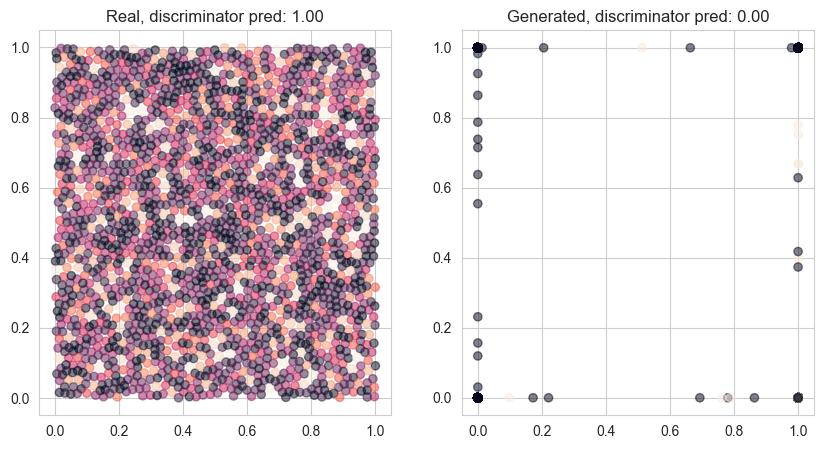

In [321]:
# Check on the created figures
def plot_sample_figures(generator, discriminator, dataset, n=5, plot_radius=True):
    sample_generated_y = generator(dataset[:][0][0:n])
    sample_y = dataset[:][1][0:n]

    # Illustrate the point cloud

    fig, ax = plt.subplots(1,2, figsize=(10,5))

    plot_pointcloud(sample_y[0], ax=ax[0], plot_radius=plot_radius)

    plot_pointcloud(sample_generated_y[0].detach().numpy(), ax=ax[1], plot_radius=plot_radius)

    # Discriminator predictions on the generated data and the real data

    real_preds = discriminator(sample_y)
    preds = discriminator(sample_generated_y)


    ax[0].set_title("Real, discriminator pred: {:.2f}".format(real_preds[0].item()))
    ax[1].set_title("Generated, discriminator pred: {:.2f}".format(preds[0].item()))

    plt.show()

    # Plot distribution of the generated data
    # sns.histplot(sample_generated_y[0].detach().numpy()[:,0], bins="auto")
    # plt.title("X")
    # plt.show()

    # sns.histplot(sample_generated_y[0].detach().numpy()[:,1], bins="auto")
    # plt.title("Y")
    # plt.show()

    # sns.histplot(sample_generated_y[0].detach().numpy()[:,2], bins="auto")
    # plt.title("R")
    # plt.show()

plot_sample_figures(generator, discriminator, dataset, n=3, plot_radius=False)

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        41.71%       5.928ms       100.00%      14.214ms      14.214ms             1  
               aten::convolution         0.27%      38.000us        30.12%       4.281ms       2.140ms             2  
              aten::_convolution        18.66%       2.652ms        29.85%       4.243ms       2.122ms             2  
          aten::conv_transpose1d         0.04%       5.000us        20.88%       2.968ms       2.968ms             1  
                     aten::randn         5.29%     752.000us        17.73%       2.520ms       2.520ms             1  
                   aten::normal_        12.40%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [ ]:
metadata.drop_duplicates()

N          L            A
experiment sample                                  
phi-0.74   sample-245  2000  46.887094  1626.815709
           sample-46   2000  46.887094  1626.815709
           sample-24   2000  46.887094  1626.815709
           sample-348  2000  46.887094  1626.815709
phi-0.72   sample-245  2000  47.533843  1626.815709
           sample-77   2000  47.533843  1626.815709
           sample-83   2000  47.533843  1626.815709
           sample-286  2000  47.533843  1626.815709